In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt

# Gridworld MDP

In [2]:
class GridworldEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    """
    This class implements a custom made Gym environment of a simple Gridworld, a NxN matrix where the agent starts from a starting position I and 
    has to reach the goal position G.
    
    The set of states S = {[x,y]| x,y ∈ [0, ..., grid_size]} or {}, represent the possible positions in the environment.
    The set of actions A = [up, down, left, right].
    The transition to a new state T(s_t+1 | s_t, a_t).
    The reward R(s, a) = {1 if s == G else -0.1}.
    
    In this version the initial state is the position 0 ([0, 0]), I = [0, 0]. The goal state is the position 24 ([4, 4]) G = [4,4]. 
    
    Args:
    - grid_size: the size in height and length of the grid, N of the NxN matrix.
    - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
    - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
    
    """
    
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1):
        self.grid_size = grid_size
        self.state_space = spaces.Discrete(self.grid_size ** 2)
        self.action_space = spaces.Discrete(4)
        self.reward_range = (-0.1, 1.0)
        self.goal = (grid_size-1, grid_size-1)
        self.current_pos = (0, 0)
        self.done = False
        self.time_horizon = time_horizon
        self.steps_taken = 0
        self.prob = prob
        self.transition_matrix = self._build_transition_matrix()
        
    def _build_transition_matrix(self):
        '''
        This method builds the transition matrix for the MDP, T(s'|a, s).
        The function should be used with the following order of operands:
         - first parameter: s, the state where the agent takes the action in
         - second parameter: s', the state where the agent arrives taking action a from state s
         - third parameter: a, the action taken by the agent
        '''
        transition_matrix = np.zeros((self.grid_size**2, self.grid_size**2, self.action_space.n))
        # For every state (i,j)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = (i, j)
                # For every action 'a' chosen as action from the agent
                for a in range(self.action_space.n):
                    # For all actions 'a_'
                    for a_ in range(self.action_space.n):
                        # Calculate the probability of 
                        prob = 1 - self.prob if a_ == a else self.prob / (self.action_space.n - 1)
                        s_ = self._sample_new_position(a_, s)
                        transition_matrix[self._state_to_index(s), self._state_to_index(s_), a] += prob
        return transition_matrix
    
    def _sample_new_position(self, action, state):
        if action == 0:  # up
            new_pos = (state[0], max(0, state[1]-1))
        elif action == 1:  # down
            new_pos = (state[0], min(self.grid_size-1, state[1]+1))
        elif action == 2:  # left
            new_pos = (max(0, state[0]-1), state[1])
        elif action == 3:  # right
            new_pos = (min(self.grid_size-1, state[0]+1), state[1])
        else:
            raise ValueError("Invalid action.")
        return new_pos
    
    def _state_to_index(self, state):
        return state[0] + state[1] * self.grid_size

    def _index_to_state(self, index):
        """Converts an index to a state tuple (i, j)."""
        i = index % self.grid_size
        j = index // self.grid_size
        #print("Converting %d => (%d, %d)" %(index, i, j))
        return (i, j)
    
    def sample_next_state(self, action):
        current_state = self._state_to_index(self.current_pos)
        action_probabilities = self.transition_matrix[current_state, :, action]
        next_state_index = np.random.choice(self.grid_size**2, p=action_probabilities)
        next_pos = self._index_to_state(next_state_index)
        #print("Taking action %d from cur_pos index:%d (%d, %d): going to index %d which is state => (%d, %d)" %(action, current_state, self.current_pos[0], self.current_pos[1], next_state_index, next_pos[0], next_pos[1]))
        return next_pos
        
    def step(self, action):
        #print("Timestep: %d" %self.steps_taken)
        if self.done:
            raise ValueError("Episode has already ended.")
        new_pos = self.sample_next_state(action)
        reward = -0.1  # default reward for moving
        if new_pos == self.goal:
            reward = 1.0
            self.done = True
        self.current_pos = new_pos
        self.steps_taken += 1
        if self.time_horizon != -1 and self.steps_taken >= self.time_horizon:
            self.done = True
        return self.current_pos, reward, self.done, {}
    
    def reset(self):
        self.current_pos = (0, 0)
        self.done = False
        self.steps_taken = 0
        return self.current_pos

    def render(self, mode='human'):
        if mode == 'human':
            for j in range(self.grid_size):
                for i in range(self.grid_size):
                    if (i, j) == self.current_pos:
                        print("X ", end='')
                    elif (i, j) == self.goal:
                        print("G ", end='')
                    else:
                        print("_ ", end='')
                print()
            print()
            
    def get_states(self):
        states = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                states.append((i, j))
        return states

# Reward Reinforce Agent MDP

In [3]:
# Define the REINFORCE agent
class REINFORCEAgent():
    '''
    This class is the implementation of a REINFORCE agent that tries to maximize the objective function J(θ)=E_(τ ~ p_π)[R(τ)]
    Args:
     - env: the instance of the environment on which the agent is acting.
     - alpha: the value of the learning rate to compute the policy update.
     - gamma: the value of the discount for the reward in order to compute the discounted reward.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.99):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.policy_params = np.zeros((env.grid_size, env.grid_size, env.action_space.n))

    def get_action(self, state):
        # Sample action from the policy
        logits = self.policy_params[state[0], state[1], :]
        probs = np.exp(logits) / np.sum(np.exp(logits))
        action = np.random.choice(len(probs), p=probs)
        return action

    def compute_returns(self, episode):
        G = 0
        returns = []
        for t in reversed(range(len(episode))):
            _, _, reward, _ = episode[t]
            G = self.gamma * G + reward
            returns.append(G)
        returns = np.array(list(reversed(returns)))
        return returns

    def update(self, episode):
        '''
        This version of the update is the Monte Carlo sampling version of the REINFORCE algorithm.
        
        Args:
         - episode: the sampled trajectory from which we compute the policy gradient.
        '''
        # Compute returns
        returns = self.compute_returns(episode)
        
        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, _, _ = episode[t]
            logits = self.policy_params[state[0], state[1], :]
            probs = np.exp(logits) / np.sum(np.exp(logits))
            dlogp = np.zeros_like(logits)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad[state[0], state[1], :] += dlogp * returns[t]
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        
    def update_gradient_approx(self, trajectories):
        '''
        This version of the update takes into consideration the approximation of the gradient approach instead of the single sampling. Instead
        of working with only one trajectory it works with multiple trajectories in order to have a more accurate representation of the expected
        value of the ∇J(θ).
        
        Args:
         - trajectories: a list of sampled trajectories from which we compute the policy gradient.
         
        '''
        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for episode in trajectories:
            for t in range(len(episode)):
                returns = self.compute_returns(episode)
                state, action, _, _ = episode[t]
                # Compute the policy gradient
                logits = self.policy_params[state[0], state[1], :]
                probs = np.exp(logits) / np.sum(np.exp(logits))
                dlogp = np.zeros_like(logits)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad[state[0], state[1], :] += dlogp * returns[t]
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad

**Test single sampling**

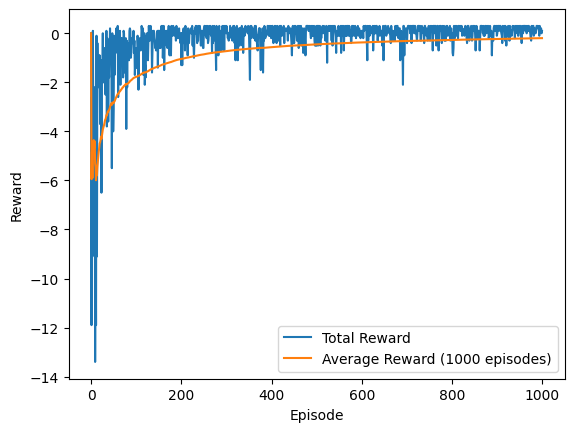

In [4]:
# Create the Gridworld environment and the REINFORCE agent
trajectories = 1000
env = GridworldEnv(time_horizon=200)
agent = REINFORCEAgent(env)

# Train the agent and plot the rewards
total_rewards = []
avg_rewards = []
fig, ax = plt.subplots()
for i in range(trajectories):
    episode = []
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        #env.render()
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward, next_state))
        state = next_state
        total_reward += reward
    agent.update(episode)
    total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards[-trajectories:])
    avg_rewards.append(avg_reward)
    ax.clear()
    ax.plot(total_rewards, label='Total Reward')
    ax.plot(avg_rewards, label='Average Reward (%d episodes)' %trajectories)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.legend()
    fig.canvas.draw()

**Test gradient approximation**

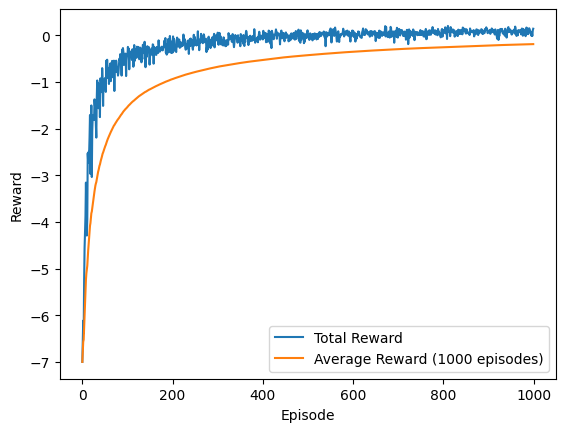

In [5]:
# Create the Gridworld environment and the REINFORCE agent
trajectories = 1000
n_traj = 20
env = GridworldEnv(time_horizon=100)
agent = REINFORCEAgent(env)

# Train the agent and plot the rewards
total_avg_rewards = []
avg_avg_rewards = []
fig, ax = plt.subplots()
for i in range(trajectories):
    trajectories = []
    total_rewards = []
    for k in range(n_traj):
        episode = []
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            #env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, next_state))
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        trajectories.append(episode)
    agent.update_gradient_approx(trajectories)
    total_avg_rewards.append(np.mean(total_rewards[-n_traj:]))
    avg_avg_reward = np.mean(total_avg_rewards[-trajectories:])
    avg_avg_rewards.append(avg_avg_reward)
    ax.clear()
    ax.plot(total_avg_rewards, label='Total Reward')
    ax.plot(avg_avg_rewards, label='Average Reward (%d episodes)' %trajectories)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.legend()
    fig.canvas.draw()

# Entropy Reinforce Agent MDP

In [4]:
class REINFORCEAgentE(REINFORCEAgent):
    '''
    This class is the extension of the previous Reinforce agent. The only change is the objective followed by the agent that this time is going
    to be the state visitation entropy J(θ) = E_(τ ~ p_π)[H(d_τ(s))] .
    '''
    def __init__(self, env, alpha=0.01, gamma=0.8):
        super().__init__(env=env, alpha=alpha, gamma=gamma)
        # Optional initialization to have a non-uniform initial policy
        self.policy_params = self.create_stupid_policy()
        
    def create_stupid_policy(self):
        params = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
        for i in range(self.env.grid_size):
            for j in range(self.env.grid_size):
                params[i,j,0] = 1
        return params
    
    def compute_state_distribution(self, episode, t):
        d_t = np.zeros((env.grid_size, env.grid_size))
        for t in range (t + 1):
            _, _ , _, s_t = episode[t]
            d_t[s_t[0]][s_t[1]] += 1
        d_t /= (t + 1)
        return d_t

    def update(self, episode):
        # Compute the t-step state distribution for the current policy
        d_t = self.compute_state_distribution(episode, len(episode) - 1)
        # Compute entropy of d_t
        entropy = 0
        for row in d_t:
            for s in row:
                if s != 0:
                    entropy -= s * np.log(s)
        
        # Update policy parameters using the gradient of the entropy of the t-step state distribution
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, _, _ = episode[t]
            # Compute the policy gradient
            logits = self.policy_params[state[0], state[1], :]
            probs = np.exp(logits) / np.sum(np.exp(logits))
            dlogp = np.zeros_like(logits)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad[state[0], state[1], :] += dlogp 
        grad *= entropy
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropy, d_t
    
    def update_gradient_approx(self, trajectories):
        # Update policy parameters using the approximated gradient of the entropy objective function
        grad = np.zeros_like(self.policy_params)
        entropies = []
        for episode in trajectories:
            # Initialize the gradient of the k-th sampled trajectory
            grad_k = np.zeros_like(self.policy_params)
            # Compute the t-step state distribution for the current policy
            d_t = self.compute_state_distribution(episode, len(episode) - 1)
            # Compute entropy of d_t
            entropy = 0
            for row in d_t:
                for s in row:
                    if s != 0:
                        entropy -= s * np.log(s)
            for t in range(len(episode)):
                state, action, _, _ = episode[t]
                # Compute the policy gradient
                logits = self.policy_params[state[0], state[1], :]
                probs = np.exp(logits) / np.sum(np.exp(logits))
                dlogp = np.zeros_like(logits)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad_k[state[0], state[1], :] += dlogp 
            grad_k *= entropy
            # Sum the k-th gradient to the final gradient
            grad += grad_k
            entropies.append(entropy)
        # Divide the gradient by the number of trajectories sampled
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropies

**Test single sampling**

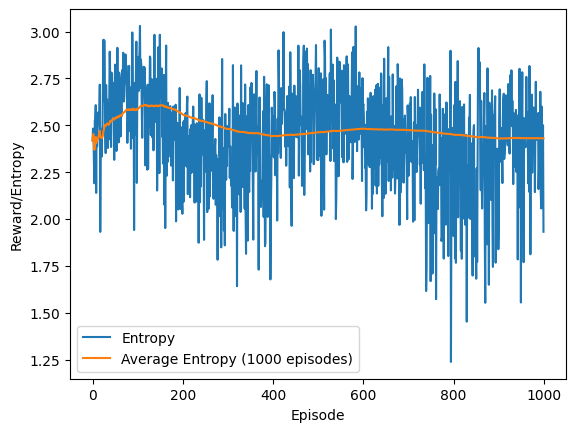

In [5]:
trajectories = 1000
env = GridworldEnv(time_horizon = 200, prob = 0.1)
agent = REINFORCEAgentE(env)

# Train the agent and plot the rewards
total_rewards = []
avg_rewards = []
entropies = []
avg_entropies = []
fig, ax = plt.subplots()
for i in range(trajectories):
    episode = []
    state = env.reset()
    done = False
    total_reward = 0
    #print("start episode %d" %i)
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward, next_state))
        state = next_state
        total_reward += reward
    #print("F")
    state = env.reset()
    entropy, d_t = agent.update(episode)
    '''
    if i % 100 == 0:
        print(d_t)
    '''
    entropies.append(entropy)
    total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards[-trajectories:])
    avg_rewards.append(avg_reward)
    avg_entropy = np.mean(entropies[-trajectories:])
    avg_entropies.append(avg_entropy)
    
    #Plot Reward and Entropy
    ax.clear()
    #ax.plot(total_rewards, label='Total Reward')
    #ax.plot(avg_rewards, label='Average Reward (%d episodes)' %episodes)
    ax.plot(entropies, label='Entropy')
    ax.plot(avg_entropies, label='Average Entropy (%d episodes)' %trajectories)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward/Entropy')
    ax.legend()
    fig.canvas.draw()

**Test gradient approximation**

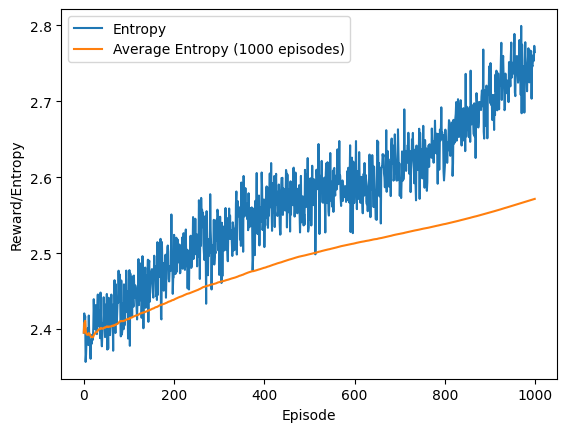

In [56]:
episodes = 1000
n_traj = 50
env = GridworldEnv(time_horizon = 200, prob = 0)
agent = REINFORCEAgentE(env)

# Train the agent and plot the rewards
avg_entropies = []
avg_avg_entropies = []
fig, ax = plt.subplots()
for i in range(episodes):
    trajectories = []
    entropies = []
    for k in range(n_traj):
        episode = []
        state = env.reset()
        done = False
        while not done:
            #env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, next_state))
            state = next_state
        trajectories.append(episode)
    entropies = agent.update_gradient_approx(trajectories)
    avg_entropies.append(np.mean(entropies[-n_traj:]))
    avg_avg_entropy = np.mean(avg_entropies[-episodes:])
    avg_avg_entropies.append(avg_avg_entropy)

    #Plot Reward and Entropy
    ax.clear()
    ax.plot(avg_entropies, label='Entropy')
    ax.plot(avg_avg_entropies, label='Average Entropy (%d episodes)' %episodes)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward/Entropy')
    ax.legend()
    fig.canvas.draw()

# Gridworld POMDP

In [10]:
class GridworldPOMDPEnv(GridworldEnv):
    '''
    This class implements the extension of the upper Gridworld MDP, making it become a POMDP by inserting the observation mechanism.
    The observations here are modeled as a probability of returning the real state of the MDP, so the agent can see the real state with
    probability obs_prob and the others with probability 1 - obs_prob.
    
    Args:
     - grid_size: the size in height and length of the grid, N of the NxN matrix.
     - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
     - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
     - obs_prob: the probability with which the environment gives back the actual state 
    '''
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, obs_prob = 0.8):
        # Initialize the underlying Gridworld MDP
        super().__init__(grid_size=grid_size, time_horizon=time_horizon, prob=prob)
        # Initialize all the POMDP specific variables
        self.observation_space = spaces.Discrete(self.grid_size**2)
        self.obs_prob = obs_prob
        self.observation_matrix = self.build_observation_matrix()
        
    def build_observation_matrix(self):
        '''
        This method creates the observation matrix for our environment.
        The observation function indexes are to be used in order:
         - first param: true state s
         - second param: observation o
        '''
        # Initialize the observation function with zeros
        observation_matrix = np.zeros((self.grid_size**2, self.grid_size**2))
        for s_i in range(self.observation_space.n):
            for s in range(self.observation_space.n):
                # For every state, put probabilty to obs_prob if the outer state is equal to the inner, otherwise to the uniform between the other states.
                observation_matrix[s_i][s] += self.obs_prob if s == s_i else (1 - self.obs_prob) / (self.observation_space.n - 1)
        # Return the built matrix
        return observation_matrix

    def reset(self):
        # Call the upper reset of the environment
        super().reset()
        # Set the initial belief to a uniform distribution and give it to the agent
        initial_belief = np.ones(self.observation_space.n) / self.observation_space.n
        return initial_belief

    def step(self, action):
        # Make the step of the underlying MDP
        true_state, reward, done, info = super().step(action)
        # Get the index of the state
        true_state_index = self._state_to_index(true_state)
        # Get the observation probabilities for the state
        obs_prob = self.observation_matrix[true_state_index]
        # Sample the next observation from the probabilities
        obs = np.random.choice(self.grid_size**2, p=obs_prob)
        # Change index to position
        obs = self._index_to_state(obs)
        return obs, reward, done, info

# Reward Reinforce POMDP

In [17]:
class REINFORCEAgentPOMDP(REINFORCEAgent):
    '''
    This calls implements the Reinforce Agent for the POMDP defined above.
    It is implemented as the extension of the former MDP agent but adds the belief state and what is concerned by it.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.99):
        super().__init__(env=env, alpha=alpha, gamma=gamma)
        self.belief = np.ones(env.grid_size**2)/(env.grid_size * env.grid_size)
        self.last_sampled_state = 0
        self.n_expected_value = 50
    
    # TODO: testino funzionamento
    def belief_update(self, action, observation):
        '''
        This method updates the belief of the agent in a Bayesian way. 
        '''
        # Get the index of the observed state
        obs_state_index = self.env._state_to_index(observation)
        # Initialize the updated belief vector
        unnormalized_updated_belief = np.zeros(self.belief.shape)
        for s in range(env.state_space.n):
            # Get O(o\s)
            obs_o_s = self.env.observation_matrix[s, obs_state_index]
            # Calculate the sum over all states
            summation = np.sum(self.env.transition_matrix[s, :, action] * self.belief, axis=0)
            b_s = obs_o_s * summation
            unnormalized_updated_belief[s] = b_s
        # Normalize the belief and update it
        self.belief = unnormalized_updated_belief / np.sum(unnormalized_updated_belief)
        
    def get_state(self, mode):
        '''
        This method is used to sample or compute the expected state given the current belief.
        Args:
         - mode: if 0 it does a single sampling of the state.
                 if 1 it gives the approximated expected value.
                 No other values allowed.
        '''
        if mode != 0 and mode != 1:
            raise Exception("You have to pass me 0 or 1, read :/")
        
        if mode == 0:
            state = np.random.choice(self.belief.size, p=self.belief)
            self.last_sampled_state = state
            state = env._index_to_state(state)
            return state
        
        if mode == 1:
            states = []
            for i in range(self.n_expected_value):
                states.append(np.random.choice(self.belief.size, p=self.belief))
            state = max(set(states), key = states.count)
            self.last_sampled_state = state
            state = env._index_to_state(state)
            return state

**Mini Test Belief Update**

In [ ]:
env = GridworldPOMDPEnv(time_horizon=100)
agent = REINFORCEAgentPOMDP(env)

# TODO

**Test code**

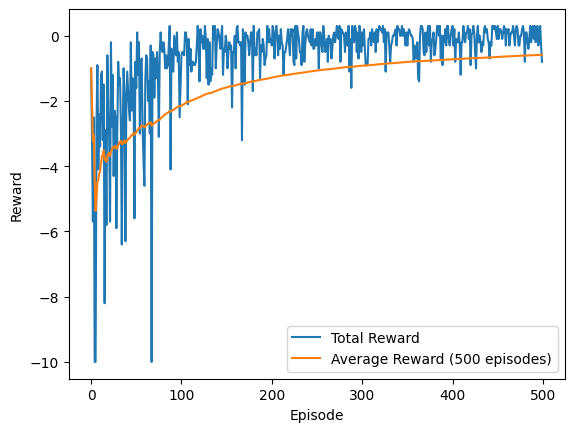

In [18]:
# Create the Gridworld environment and the REINFORCE agent
episodes = 500
env = GridworldPOMDPEnv(time_horizon=100)
agent = REINFORCEAgentPOMDP(env)

# Train the agent and plot the rewards
total_rewards = []
avg_rewards = []
fig, ax = plt.subplots()
for i in range(episodes):
    episode = []
    agent.belief = env.reset()
    done = False
    total_reward = 0
    while not done:
        sampled_state = agent.get_state(1)
        action = agent.get_action(sampled_state)
        next_obs, reward, done, _ = env.step(action)
        episode.append((sampled_state, action, reward, next_obs))
        agent.belief_update(action, next_obs)
        total_reward += reward
    agent.update(episode)
    total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards[-episodes:])
    avg_rewards.append(avg_reward)
    ax.clear()
    ax.plot(total_rewards, label='Total Reward')
    ax.plot(avg_rewards, label='Average Reward (%d episodes)' %episodes)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.legend()
    fig.canvas.draw()

# Entropy Reinforce POMDP